# Úkol č. 2 - předzpracování dat a binární klasifikace (do 9. listopadu 23:59)

  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny vhodné k trénování modelu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí křížové validace. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor s predikcemi pro vyhodnocovací data (`results.csv`).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

In [524]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('data.csv')

## Podpůrné funkce

In [525]:
# Normalize dataframe values for classification
def get_scaled_df(df):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

# Revert age normalization
def invert_age(df, min_age, max_age):
    df['age'] = df['age']*(max_age-min_age) + min_age
    return df

# Scikit approach to fill nulls by KNN imputation
def fill_nulls_knn(df):
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    return pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

# Custom aproach to fill nulls in age feature
def fill_nulls_dist(df, origin):
    df['age'] = df['age'].map(lambda l: l if not np.isnan(l) else np.random.choice(origin))
    return df

## Přidání příznaků
Přidání titulu

In [526]:
def add_title(df):
    titles_regex = {'(.*Mr\..*)' : 'Mr','(.*Dr\..*)' : 'Dr', '(.*Mrs\..*)' : 'Mrs' , '(.*Miss\..*)' : 'Miss', '(.*Master\..*)' : 'Master'}
    def l(x):
        for k in titles_regex.keys():
            reg = re.compile(k)
            match = reg.search(x['name'])
            if match is not None:
                return titles_regex[k]
        return None
    df['title'] = df.apply(lambda x: l(x), axis=1)
    return df

In [527]:
df = add_title(df)

## Transormace příznaků
Budu zkoušet 2 různé přístupy. První je transofrmace příznaků pomocí číselných kategorií. Tento přístup bych rád porovnal s metodou "one hot encoding".

## Zbavení se příznaků
Zbavíme se příznaků, které mají více než 40% chybějících hodnot a příznaků, které nemají pro klasifikaci význam.

In [528]:
for c in df.columns:
    nulls = df[c].isna().sum()
    if nulls > 400:
        print(c, nulls)
        df.pop(c)
to_drop = ['ticket', 'name', 'ID']
df.drop(to_drop, axis=1, inplace=True)
df_categories = df.copy()

cabin 774
home.dest 446


In [529]:
df_dummies = df.copy()
cols = df_dummies[['embarked', 'sex', 'title', 'pclass']]
df_dummies = pd.get_dummies(df_dummies, columns=['embarked', 'sex', 'title', 'pclass'])

In [530]:
df_categories['embarked'] = df['embarked'].astype('category').cat.codes
df_categories['sex'] = df['sex'].astype('category').cat.codes
df_categories['title'] = df['title'].astype('category').cat.codes
df_categories['pclass'] = df['pclass'].astype('category').cat.codes

## Chybějící hondoty
Budeme doplnovat chybějící hodnoty to featury age, nejprve pomocí KNN imputace a poté pomocí takové funkce, aby byla zachována distribuce věků.

### KNN imputation

In [531]:
max_age = df_dummies['age'].max()
min_age = df_dummies['age'].min()
null_mask = df_dummies['age'].isnull()

In [532]:
df_dummies_knn = invert_age(fill_nulls(get_scaled_df(df_dummies)), max_age, min_age)
df_categories_knn = invert_age(fill_nulls(get_scaled_df(df_categories)), max_age, min_age)

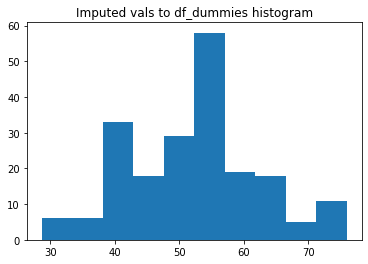

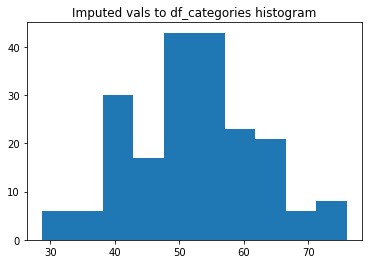

In [533]:
plt.hist(df_dummies_knn[null_mask]['age'], bins=10)
plt.title('Imputed vals to df_dummies histogram')
plt.show()
plt.hist(df_categories_knn[null_mask]['age'], bins=10)
plt.title('Imputed vals to df_categories histogram')
plt.show()

### "Distribution" imputation
Doplníme věk tak, že bude mít stejnou distribuci hodnot jako původní množina věků, která neobsahuje hodnoty "NaN".

In [534]:
df_dummies_dist = df_dummies.copy()
df_dummies_dist = fill_nulls_dist(df_dummies_dist, df['age'].dropna())

df_cat_dist = df_categories.copy()
df_cat_dist = fill_nulls_dist(df_cat_dist, df['age'].dropna())

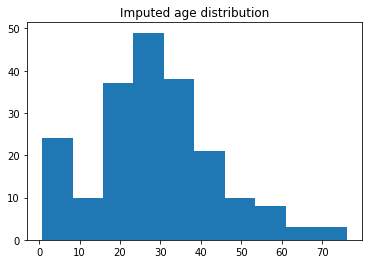

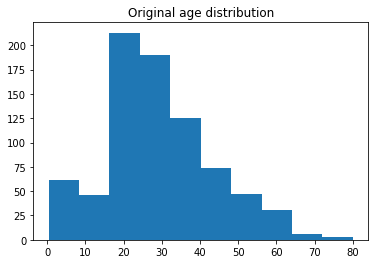

In [535]:
plt.hist(df_dummies_dist[null_mask]['age'], bins=10)
plt.title('Imputed age distribution')
plt.show()

plt.hist(df_origin[~null_mask]['age'], bins=10)
plt.title('Original age distribution')
plt.show()

Vidíme, že distribuce je 

## Výběr klasifikátoru

In [536]:
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import model_selection
scaler = MinMaxScaler()
df_categories = pd.DataFrame(scaler.fit_transform(df_categories), columns = df_categories.columns)
df_dummies = pd.DataFrame(scaler.fit_transform(df_dummies), columns = df_dummies.columns)

In [537]:
def get_accuracy(df, calssifier):
    X = df.drop('survived', axis=1)
    Y = df['survived'].astype('int64')
    score = cross_val_score(calssifier, X, Y)
    return score.max(), score.min()

In [538]:
clf_tree = tree.DecisionTreeClassifier(), "Decision tree"
clf_svm = svm.SVC(), 'Support vector machine'
clf_forest = RandomForestClassifier(), 'Random forrest'
clf_knn = KNeighborsClassifier(), 'KNN'
clf_ada = AdaBoostClassifier(), 'Ada boost'
gnb = GaussianNB(), 'Naive bayess'
for d in [df_dummies_dist, df_cat_dist, df_dummies_knn, df_categories_knn]:
    for c in [clf_tree, clf_svm, clf_forest, clf_knn, clf_ada, gnb]:
        res = get_accuracy(d, c[0])
        res_max = round(res[0]*100, 2)
        res_min = round(res[1]*100, 2)
        print('{0} has accuracy max {1}% and min {2}%, spread: {3}'.format(c[1], res_max , res_min, res_max-res_min))
    print()

Decision tree has accuracy max 76.0% and min 70.5%, spread: 5.5
Support vector machine has accuracy max 68.5% and min 64.5%, spread: 4.0
Random forrest has accuracy max 81.5% and min 74.5%, spread: 7.0
KNN has accuracy max 68.5% and min 66.5%, spread: 2.0
Ada boost has accuracy max 82.0% and min 74.5%, spread: 7.5
Naive bayess has accuracy max 80.5% and min 71.0%, spread: 9.5

Decision tree has accuracy max 79.0% and min 69.5%, spread: 9.5
Support vector machine has accuracy max 68.5% and min 64.5%, spread: 4.0
Random forrest has accuracy max 79.0% and min 75.0%, spread: 4.0
KNN has accuracy max 67.5% and min 62.5%, spread: 5.0
Ada boost has accuracy max 83.0% and min 74.5%, spread: 8.5
Naive bayess has accuracy max 80.0% and min 71.5%, spread: 8.5

Decision tree has accuracy max 82.5% and min 74.5%, spread: 8.0
Support vector machine has accuracy max 61.0% and min 59.5%, spread: 1.5
Random forrest has accuracy max 83.5% and min 75.0%, spread: 8.5
KNN has accuracy max 79.5% and min 72.

Nejlepe vychází knn_dummies dataframe na decsion tree, pokračujme tedy s ním.

## Nalezení vhodných hypermaratemtrů pro decision tree na datech df_dummies_knn

In [539]:
param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(5, 15),
        'splitter': ['best', 'random'],
        'min_samples_split': range(2, 8),
        'min_samples_leaf': range(1, 8)
    }

In [540]:
X = df_dummies_knn.drop('survived', axis=1)
Y = df_dummies_knn['survived'].astype('int64')
hparams = model_selection.ParameterGrid(param_grid)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.33)
# getting accuracy of each parameter combination
accuracies_train = []
accuracies_test = []
for x in hparams:
    model_tmp = tree.DecisionTreeClassifier(**x)
    # Accuracy on test
    model_tmp.fit(X_train, y_train)
    predicted = model_tmp.predict(X_test)
    acc = metrics.accuracy_score(y_test, predicted)
    accuracies_test.append(acc)
    # Accuracy on train
    model_tmp.fit(X, Y)
    predicted = model_tmp.predict(X)
    acc = metrics.accuracy_score(Y, predicted)
    accuracies_train.append(acc)

hparams_best_train = hparams[np.argmax(accuracies_train)]
hparams_best_test = hparams[np.argmax(accuracies_test)]

print(f'Přesnost na trénovací množině: {round(np.max(accuracies_train) * 100)}%')
print(f'Přesnost na testovací množině: {round(np.max(accuracies_test) * 100)}%')

print(f'Best hyperparameters for the model were:\n{hparams_best_test} with accuracy {round(np.max(accuracies_test) * 100)} %')
best_tree = tree.DecisionTreeClassifier(**hparams_best_test)
best_tree.fit(X_train, y_train)

Přesnost na trénovací množině: 97%
Přesnost na testovací množině: 82%
Best hyperparameters for the model were:
{'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 8, 'criterion': 'gini'} with accuracy 82 %


DecisionTreeClassifier(max_depth=8, min_samples_leaf=6, min_samples_split=5,
                       splitter='random')

## Predikce

In [545]:
df = pd.read_csv('evaluation.csv')
df_origin = df.copy()
df_id = df.ID
df = add_title(df)
to_drop = ['ticket', 'name', 'ID', 'cabin', 'home.dest']
df.drop(to_drop, axis=1, inplace=True)
cols = df[['embarked', 'sex', 'title', 'pclass']]
df = pd.get_dummies(df, columns=['embarked', 'sex', 'title', 'pclass'])
max_age = df['age'].max()
min_age = df['age'].min()
df = invert_age(fill_nulls(get_scaled_df(df)), max_age, min_age)

In [546]:
res = pd.DataFrame(columns=['ID', 'survived'])
res['ID'] = df_origin.ID
res['survived'] = best_tree.predict(df)

In [547]:
res.to_csv('results.csv')